Goal is to explore the data, showing levels of data distribution and choose which groups to be used for the later analysis

In [1]:
import seaborn as sns
import collections as col
import pandas as pd
import statistics
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from pathlib import Path
import gseapy as gp
import functions_sheet as myfunc
from gseapy import barplot, dotplot
import re
import upsetplot as usp
from collections import Counter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)

path_to_go_files = "/nfs/data3/IHEC/TF_PRIO/additional_files/GO_files/general"
path_to_main_comparison_dir = "/nfs/data3/IHEC/TF_PRIO/comparisons/cells"
path_to_figure_folder = "/nfs/data3/IHEC/TF_PRIO/created_plots/1_data_selection"

# read in data

Question: explain where data originated from?
* "rna_seq_data.txt" was created by listing all files in the folder of the downloaded RNAseq data and piping the output into a .txtfile
* "IHEC_metadata_harmonization.v1.1.csv" & "epiatlas_metadata.csv" were given by the QM (IHEC paper contributor)

In [2]:
# read in epiatlas metadata
df_epiatlas = pd.read_csv("epiatlas_metadata.csv")
df_metadata = pd.read_csv("IHEC_metadata_harmonization.v1.1.csv")
df_metadata = df_metadata.replace("primary cell culture","primary cell")

#filter metadata for sample_ontology and biomaterial_type
df_metadata_filtered = df_metadata[["epirr_id_without_version","harmonized_biomaterial_type",
                                    "harmonized_sample_ontology_intermediate","harmonized_sample_disease_high", 
                                    "harmonized_sample_disease_intermediate","harmonized_sample_disease"]]

#merge dataframes
df_merge = pd.merge(df_epiatlas, df_metadata_filtered, left_on="epirr_id_without_version", right_on="epirr_id_without_version")

# Filter merge df for histon modifications and just keep informative columns
experiment_types_2_keep = ["H3K27ac","H3K27me3","H3K36me3","H3K4me1","H3K4me3","H3K9me3"]
df_merge_filter = df_merge[df_merge["experiment_type"].isin(experiment_types_2_keep)]
df_merge_filter = df_merge_filter[["epirr_id","epirr_id_without_version", "experiment_type", "data_file_path",
                                   "harmonized_biomaterial_type","harmonized_sample_ontology_intermediate",
                                   "harmonized_sample_disease_high","harmonized_sample_disease_intermediate","harmonized_sample_disease"]]

# Cast long to wide
df_path_links = df_merge_filter.pivot(index=["epirr_id","epirr_id_without_version","harmonized_sample_ontology_intermediate"
                                             ,"harmonized_biomaterial_type","harmonized_sample_disease_high","harmonized_sample_disease_intermediate",
                                             "harmonized_sample_disease"], columns="experiment_type", values="data_file_path")


# Read in all available imputed peaks and fill in accordingly the paths if NaN values in path_df
imputed_files_list = []
with open("all_files.txt", "r") as file:
    for line in file:
        imputed_files_list.append(line.strip())

for i in range(len(imputed_files_list)):
    new_val = imputed_files_list[i].split("/")[-1]
    imputed_files_list[i] = new_val
    
for row in range(df_path_links.shape[0]):
    for col in range(df_path_links.shape[1]):
        if pd.isna(df_path_links.iat[row, col]):
            hist_mod = df_path_links.columns[col]
            epirr_id = df_path_links.index[row][0]
            file_name = "impute_"+epirr_id+"_"+hist_mod+".pval.bw.narrowPeak.gz"
            if file_name in imputed_files_list:
                path = "IHEC/incoming/ChIP-Seq_imputed/imputed_peaks/narrowPeak/"+hist_mod+"/impute_"+epirr_id+"_"+hist_mod+".pval.bw.narrowPeak.gz"
                df_path_links.iat[row, col] = path
                
# replace paths with "imputed" and "experimental" according to data
def replace_if_starts_with(value, prefix, replacement):
    if isinstance(value, str):
        if value.startswith(prefix):
            return replacement
        else:
            return value

df_index = df_path_links.reset_index()
df_index = df_index.applymap(lambda x: replace_if_starts_with(x, "IHEC/", "imputed"))
df_index = df_index.applymap(lambda x: replace_if_starts_with(x, "incoming", "experimental"))

#read in rna_seq IHEC numbers
rna_seq_files = []
with open("rna_seq_data.txt", "r") as file:
    for line in file:
        # Remove the trailing newline character and add the line to the list
        rna_seq_files.append(line.strip())

for i in range(len(rna_seq_files)):
    new_val = rna_seq_files[i].split("/")[-1]
    rna_seq_files[i] = new_val

parsed_data = []
for entry in rna_seq_files:
    complete_entry = entry
    ihec_number = entry.split('.')[5]
    content_type = "genes" if "genes" in entry else "isoforms"
    file_type = ".md5" if entry.endswith(".md5") else ".results"
    parsed_data.append([ihec_number, content_type, file_type, complete_entry])


df_rna_seq = pd.DataFrame(parsed_data, columns=['IHEC Number', 'Content Type', 'File Type', "complete_filename"])

#setting RNA_seq availability values according to rna_seq_data.txt
df_index["total_RNA_seq_data_available"] = False
df_index["mRNA_seq_data_available"] = False
total_rna_seq_ihec = df_epiatlas[(df_epiatlas["assay_type"]=="RNA-Seq")&(df_epiatlas["experiment_type"]=="total-RNA-Seq")]["epirr_id_without_version"]
df_index["total_RNA_seq_data_available"]=df_index["epirr_id_without_version"].isin(total_rna_seq_ihec)
mrna_seq_ihec = df_epiatlas[(df_epiatlas["assay_type"]=="RNA-Seq")&(df_epiatlas["experiment_type"]=="mRNA-Seq")]["epirr_id_without_version"]
df_index["mRNA_seq_data_available"]=df_index["epirr_id_without_version"].isin(mrna_seq_ihec)

# Show distribution of (intermediate) ontology samples

In [7]:
grouped_df = df_index.groupby('harmonized_sample_ontology_intermediate')['harmonized_biomaterial_type'].value_counts().unstack(fill_value=0)

In [8]:
grouped_df.head()

harmonized_biomaterial_type,cell line,primary cell,primary tissue
harmonized_sample_ontology_intermediate,,,
B cell derived cell line,2,0,0
KMS-11,1,0,0
T cell,0,234,0
brain,0,0,316
cancer cell line,10,0,0


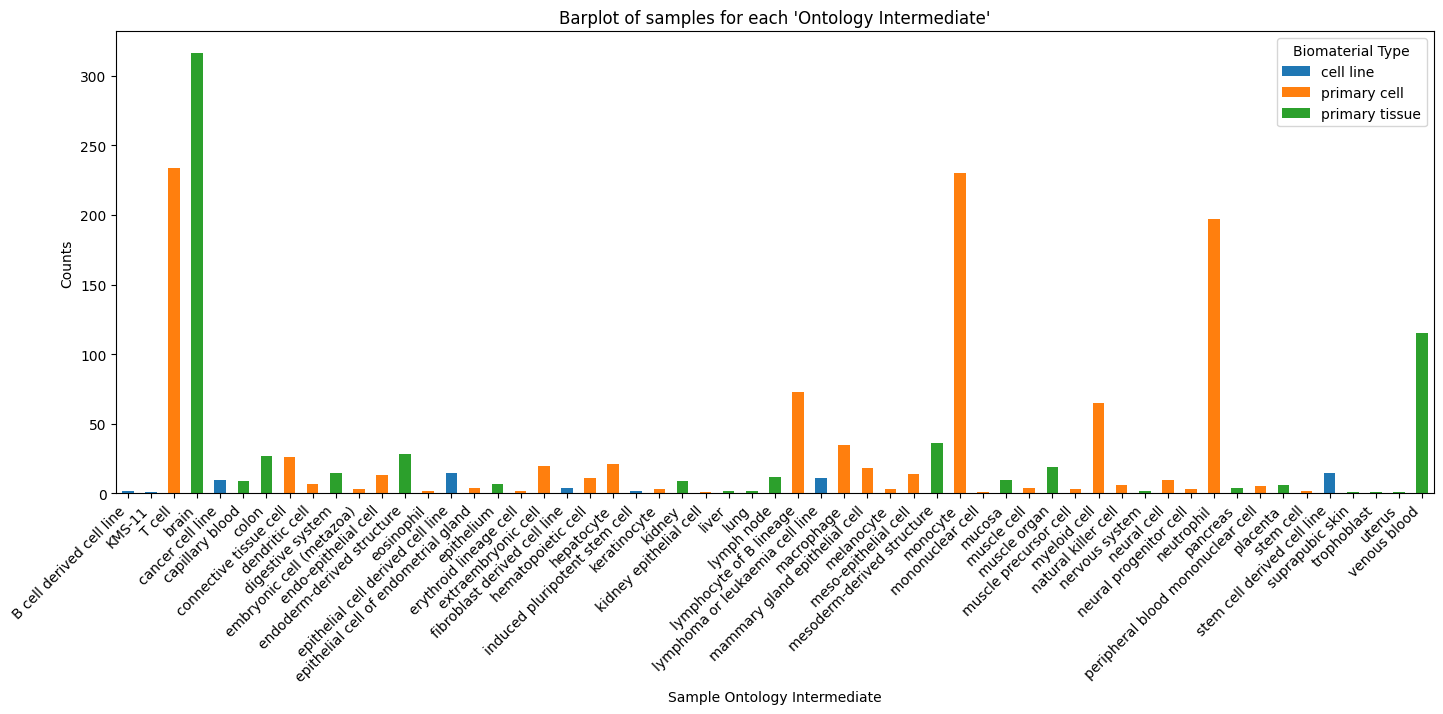

In [12]:
ax = grouped_df.plot(kind="bar", stacked=True, figsize=(17, 6))

ax.set_xlabel("Sample Ontology Intermediate")
plt.xticks(rotation=45, ha="right")
ax.set_ylabel("Counts")
plt.title("Barplot of samples for each 'Ontology Intermediate'")

plt.legend(title="Biomaterial Type", loc="upper right")

figure_file_name = "Barplot_sample_ontology"
plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches="tight")


# Barplot for histone distribution of experimental vs computed 

Creating experimental / imputed count df for the histons 

In [20]:
count_df = pd.DataFrame(columns=["Column", "Experimental", "Imputed"])

# Iterate through columns and count 'experimental' and 'imputed' values
for column in df_index.columns[7:-2]: 
    counts = df_index[column].value_counts()
    experimental_count = counts.get("experimental", 0)
    imputed_count = counts.get("imputed", 0)
    count_df = count_df.append({"Column": column, "Experimental": experimental_count, "Imputed": imputed_count}, ignore_index=True)

count_df = count_df.rename(columns={"Column": "Histon"})

counts = {
    "Experimental": count_df["Experimental"],
    "Imputed": count_df["Imputed"]
}

histons = count_df["Histon"]

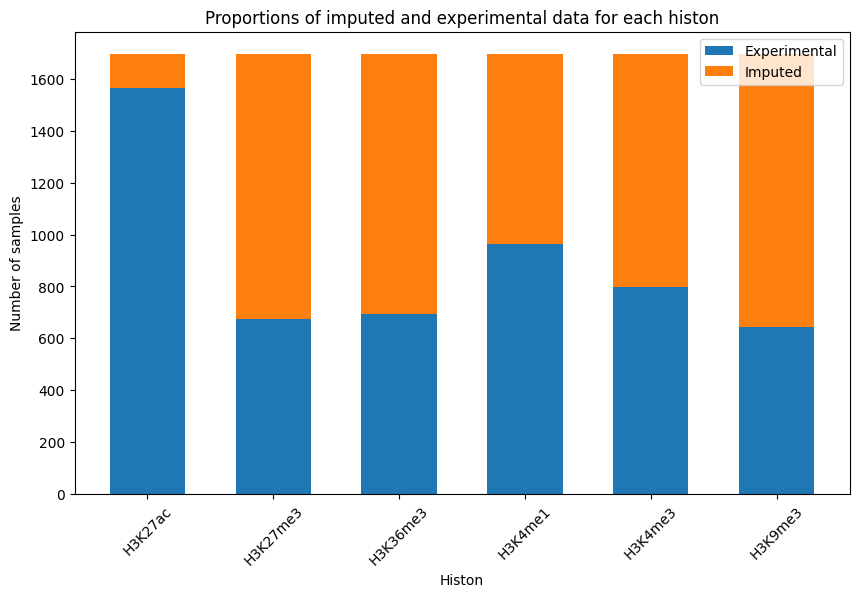

In [21]:
plt.figure(figsize=(10, 6))

bar_width = 0.6
bar_positions = range(len(count_df))

# Plot counts for experimental and imputed samples
plt.bar(bar_positions, count_df["Experimental"], bar_width, label="Experimental", color="tab:blue")
plt.bar(bar_positions, count_df["Imputed"], bar_width, bottom=count_df["Experimental"], label="Imputed", color="tab:orange")

# Add labels and title
plt.xlabel("Histon")
plt.ylabel("Number of samples")
plt.title("Proportions of imputed and experimental data for each histon")
plt.xticks(bar_positions, count_df["Histon"], rotation=45)
plt.legend()

figure_file_name = "Barplot_histon_experimental_imputed"
plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')

# Percentage of reduction by TPM filter

creating the TF dataframe with a TPM filter of 1 and showing the sizes of the resulting TF sets

In [23]:
tf_overlap_df_tpm = myfunc.create_overlap_df_with_tpm(path_to_main_comparison_dir, tpm_filter=1)
#tf_overlap_df_tpm_changed = myfunc.add_overlap_union_unique_shared_with_all_or_once(tf_overlap_df_tpm)
#tf_overlap_df_tpm_changed = tf_overlap_df_tpm_changed.rename(columns={"euchromatin": "active_marks", "heterochromatin": "suppressive_marks"})
#tf_overlap_df_tpm_changed = tf_overlap_df_tpm_changed.drop(columns=["union", "unique", "shared_at_least_once", "shared_with_all"])
tf_overlap_df_tpm.applymap(lambda x: len(x))

,suppressive_marks,active_marks
macrophage-healthy-neutrophil-healthy,27,80
macrophage-healthy-monocyte-healthy,39,46
b-cells-healthy-t-cell-healthy,45,80
macrophage-healthy-t-cell-healthy,79,61
b-cells-healthy-monocyte-healthy,38,83
monocyte-healthy-neutrophil-healthy,37,88
t-cell-healthy-neutrophil-healthy,33,67
b-cells-healthy-macrophage-healthy,80,46
b-cells-healthy-b-cells-leukemia,21,100
monocyte-healthy-t-cell-healthy,28,71


creating the TF dataframe with a TPM filter of 0 and showing the sizes of the resulting TF sets

In [24]:
tf_overlap_df_tpm_0 = myfunc.create_overlap_df_with_tpm(path_to_main_comparison_dir, tpm_filter=0)
#tf_overlap_df_tpm_0 = myfunc.add_overlap_union_unique_shared_with_all_or_once(tf_overlap_df_tpm_0)
#tf_overlap_df_tpm_0 = tf_overlap_df_tpm_0.rename(columns={"euchromatin": "active_marks", "heterochromatin": "suppressive_marks"})
#tf_overlap_df_tpm_0 = tf_overlap_df_tpm_0.drop(columns=["union", "unique", "shared_at_least_once", "shared_with_all"])
tf_overlap_df_tpm_0.applymap(lambda x: len(x))

,suppressive_marks,active_marks
macrophage-healthy-neutrophil-healthy,78,276
macrophage-healthy-monocyte-healthy,130,144
b-cells-healthy-t-cell-healthy,117,218
macrophage-healthy-t-cell-healthy,221,179
b-cells-healthy-monocyte-healthy,103,245
monocyte-healthy-neutrophil-healthy,103,268
t-cell-healthy-neutrophil-healthy,103,210
b-cells-healthy-macrophage-healthy,215,134
b-cells-healthy-b-cells-leukemia,58,260
monocyte-healthy-t-cell-healthy,73,195


creating a dataframe which shows how much of the original value is kept when applying the TPM filter

In [25]:
tf_percentage_remaining = round((tf_overlap_df_tpm.applymap(lambda x: len(x)) /tf_overlap_df_tpm_0.applymap(lambda x: len(x)))*100,2)
tf_percentage_remaining

,suppressive_marks,active_marks
macrophage-healthy-neutrophil-healthy,34.62,28.99
macrophage-healthy-monocyte-healthy,30.00,31.94
b-cells-healthy-t-cell-healthy,38.46,36.70
macrophage-healthy-t-cell-healthy,35.75,34.08
b-cells-healthy-monocyte-healthy,36.89,33.88
monocyte-healthy-neutrophil-healthy,35.92,32.84
t-cell-healthy-neutrophil-healthy,32.04,31.90
b-cells-healthy-macrophage-healthy,37.21,34.33
b-cells-healthy-b-cells-leukemia,36.21,38.46
monocyte-healthy-t-cell-healthy,38.36,36.41


Creating dataframe that shows the percentage of lost TFs

In [28]:
tf_percentage_removed = round(((tf_overlap_df_tpm_0.applymap(lambda x: len(x)) - tf_overlap_df_tpm.applymap(lambda x: len(x))) /tf_overlap_df_tpm_0.applymap(lambda x: len(x)))*100,2)

,suppressive_marks,active_marks
macrophage-healthy-neutrophil-healthy,65.38,71.01
macrophage-healthy-monocyte-healthy,70.00,68.06
b-cells-healthy-t-cell-healthy,61.54,63.30
macrophage-healthy-t-cell-healthy,64.25,65.92
b-cells-healthy-monocyte-healthy,63.11,66.12
monocyte-healthy-neutrophil-healthy,64.08,67.16
t-cell-healthy-neutrophil-healthy,67.96,68.10
b-cells-healthy-macrophage-healthy,62.79,65.67
b-cells-healthy-b-cells-leukemia,63.79,61.54
monocyte-healthy-t-cell-healthy,61.64,63.59


In [31]:
tf_percentage_removed_percentage_string = tf_percentage_removed.applymap(lambda x: "- "+str(x)+"%")
tf_percentage_removed_percentage_string

,suppressive_marks,active_marks
macrophage-healthy-neutrophil-healthy,- 65.38%,- 71.01%
macrophage-healthy-monocyte-healthy,- 70.0%,- 68.06%
b-cells-healthy-t-cell-healthy,- 61.54%,- 63.3%
macrophage-healthy-t-cell-healthy,- 64.25%,- 65.92%
b-cells-healthy-monocyte-healthy,- 63.11%,- 66.12%
monocyte-healthy-neutrophil-healthy,- 64.08%,- 67.16%
t-cell-healthy-neutrophil-healthy,- 67.96%,- 68.1%
b-cells-healthy-macrophage-healthy,- 62.79%,- 65.67%
b-cells-healthy-b-cells-leukemia,- 63.79%,- 61.54%
monocyte-healthy-t-cell-healthy,- 61.64%,- 63.59%


# Showing affinity distribution

In [2]:
tg_df = myfunc.read_out_top_target_genes(path_to_main_comparison_dir, form="whole_dataframes")

In [3]:
affinities = sum(tg_df["affinity"], [])
filtered_affinities = [x for x in affinities if x >= 0.05]

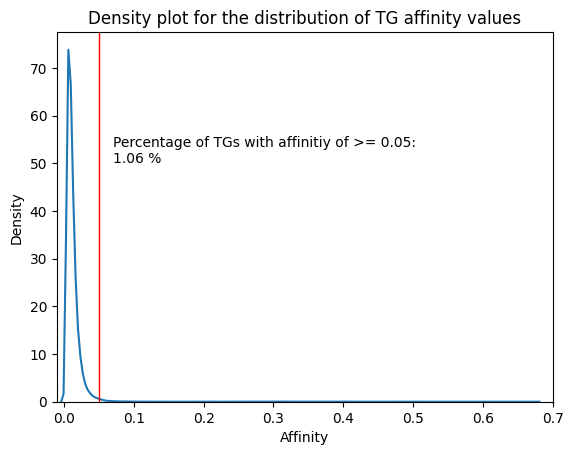

In [13]:
ax = sns.kdeplot(affinities)
percentage = round(len(filtered_affinities)/len(affinities),4)*100

plt.xlim(-0.01, 0.7)
plt.axvline(x=0.05, color='r', linestyle='-', linewidth=1)
plt.xlabel("Affinity")
ax.text(0.07, 50, "Percentage of TGs with affinitiy of >= 0.05: \n"+str(percentage)+" %")
plt.title("Density plot for the distribution of TG affinity values")

figure_file_name = "Affinity_distribution_Density_plot"
plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')

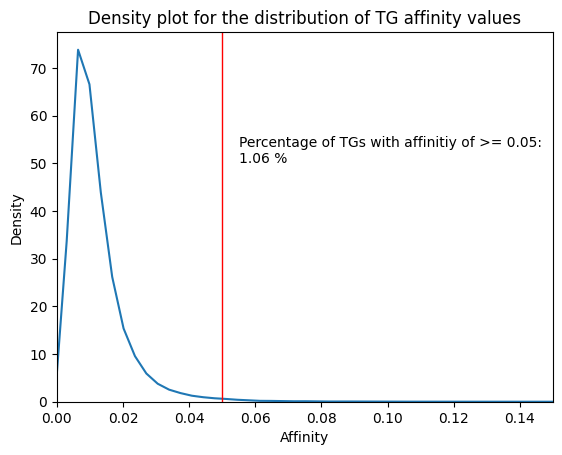

In [12]:
ax = sns.kdeplot(affinities)
percentage = round(len(filtered_affinities)/len(affinities),4)*100

ax.text(0.055, 50, "Percentage of TGs with affinitiy of >= 0.05: \n"+str(percentage)+" %")
plt.xlim(0, 0.15)
plt.axvline(x=0.05, color='r', linestyle='-', linewidth=1)
plt.xlabel("Affinity")

plt.title("Density plot for the distribution of TG affinity values")

figure_file_name = "Affinity_distribution_Density_plot_limited_x_axis"
plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')